In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import glob
from scipy import stats
import datetime as dt
from matplotlib.pylab import rcParams

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#8.1

##8.1(a) Load and Prepare Data

In [64]:
# Load data from csv 3 files
# acceleration.txt, heartrate.txt, labeled_sleep.txt
ACC = pd.read_csv('/content/drive/MyDrive/Colab Data/acceleration.txt', sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('/content/drive/MyDrive/Colab Data/heartrate.txt', sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('/content/drive/MyDrive/Colab Data/labeled_sleep.txt', sep = ' ',names=['timedelta', 'sleep'])

In [65]:
# Check ‘timedelta’ max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()

HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()

SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_date = SleepL['timedelta'].min()


print('ACC start: ',ACC_min_date ,'ACC end: ',ACC_max_date)
print('HeartR start: ',HeartR_min_date ,'HeartR end: ',HeartR_max_date)
print('SleepL start: ',SleepL_min_date ,'SleepL end: ',SleepL_max_date)

ACC start:  97.0 ACC end:  17643.046417
HeartR start:  -556410.36066 HeartR end:  16980.47229
SleepL start:  0 SleepL end:  16980


In [66]:
#set start timedelta
start_timedelta = 0
#set end timedelta
end_timedelta = 16980

ACC_new = ACC[(ACC['timedelta'] >= start_timedelta) &(ACC['timedelta'] <= end_timedelta) ]
HeartR_new = HeartR[(HeartR['timedelta'] >= start_timedelta) &(HeartR['timedelta'] <= end_timedelta) ]
SleepL_new = SleepL[(SleepL['timedelta'] >= start_timedelta) &(SleepL['timedelta'] <= end_timedelta) ]

In [67]:
ACC_new

,timedelta,accX,accY,accZ
0,97.000000,0.914566,NaN,NaN
1,1218.423666,-0.256088,-0.303055,0.913590
2,1218.443521,-0.257050,-0.304062,0.911636
3,1218.463597,-0.255585,-0.303543,0.913590
4,1218.483556,-0.256073,-0.302094,0.912125
...,...,...,...,...
788976,16979.905934,-0.442413,-0.527573,0.723450
788977,16979.925889,-0.441925,-0.527573,0.721985
788978,16979.945849,-0.441437,-0.526108,0.721985
788979,16979.965927,-0.443405,-0.525116,0.723434


##8.1(b) Load and Prepare Data (ACC)

In [68]:
# ------------ Rounding ACC (Rounding to 1 sec) -------------------------------
# Convert to datetime and round to second,
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))

#เวลาที่ duplicate ให้ปัดเป็น mean 
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean().reset_index()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean().reset_index()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean().reset_index()

ACC_new2 = pd.concat([df_acc_X, df_acc_Y['accY'], df_acc_Z['accZ']], axis=1)
ACC_new2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,timedelta,accX,accY,accZ
0,0 days 00:01:37,0.914566,NaN,NaN
1,0 days 00:20:18,-0.256199,-0.303188,0.912735
2,0 days 00:20:19,-0.256069,-0.302910,0.912509
3,0 days 00:20:20,-0.255648,-0.302149,0.912890
4,0 days 00:20:21,-0.255845,-0.302151,0.912779
...,...,...,...,...
15759,0 days 04:42:56,-0.442763,-0.525892,0.722950
15760,0 days 04:42:57,-0.441990,-0.525476,0.723410
15761,0 days 04:42:58,-0.441581,-0.525116,0.724003
15762,0 days 04:42:59,-0.442283,-0.525849,0.723265


##8.1 (c) Load and Prepare Data (Heart rate)

In [69]:
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],unit='s').round('1s'))

resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,heartrate
timedelta,
0 days 00:00:08,97.0
0 days 00:00:09,97.0
0 days 00:00:10,97.0
0 days 00:00:11,97.0
0 days 00:00:12,97.0
...,...
0 days 04:42:51,75.0
0 days 04:42:52,75.0
0 days 04:42:53,75.0


##8.1 (d) Load and Prepare Data (Sleep Label)

In [70]:
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],unit='s').round('1s'))

# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2

,sleep
timedelta,
0 days 00:00:00,-1.0
0 days 00:00:01,-1.0
0 days 00:00:02,-1.0
0 days 00:00:03,-1.0
0 days 00:00:04,-1.0
...,...
0 days 04:42:56,0.0
0 days 04:42:57,0.0
0 days 04:42:58,0.0


##8.1(e) Merge Data and Standardized data

In [71]:
df = []
df = pd.merge_asof(ACC_new2, HeartR_new2, on='timedelta')
df = pd.merge_asof(df, SleepL_new2, on = 'timedelta')

In [72]:
count_check =df.isnull().sum()
count_check

timedelta    0
accX         0
accY         1
accZ         1
heartrate    0
sleep        0
dtype: int64

In [73]:
fillAccX= df['accX'].median()
df['accX']=df['accX'].fillna(fillAccX)
fillAccY = df['accY'].median()
df['accY']=df['accY'].fillna(fillAccY)
fillAccZ = df['accZ'].median()
df['accZ']=df['accZ'].fillna(fillAccY)
fillHeartRate = df['heartrate'].median()
df['heartrate']=df['heartrate'].fillna(fillHeartRate)
fillSleep = df['sleep'].median()
df['sleep']=df['sleep'].fillna(fillSleep)

In [74]:
re_check =df.isnull().sum()
re_check

timedelta    0
accX         0
accY         0
accZ         0
heartrate    0
sleep        0
dtype: int64

In [75]:
df = df.drop(columns = ['timedelta'])
df

,accX,accY,accZ,heartrate,sleep
0,0.914566,-0.132058,-0.132058,84.0,-1.0
1,-0.256199,-0.303188,0.912735,85.0,0.0
2,-0.256069,-0.302910,0.912509,85.0,0.0
3,-0.255648,-0.302149,0.912890,85.0,0.0
4,-0.255845,-0.302151,0.912779,88.0,0.0
...,...,...,...,...,...
15759,-0.442763,-0.525892,0.722950,76.0,0.0
15760,-0.441990,-0.525476,0.723410,76.0,0.0
15761,-0.441581,-0.525116,0.724003,76.0,0.0
15762,-0.442283,-0.525849,0.723265,76.0,0.0


In [76]:
feature_columns = ['accX','accY','accZ','heartrate']
label_columns = ['sleep']

df_feature = df[feature_columns]
df_label = df[label_columns]
#standardized
standard_scaler = StandardScaler()
afterScaler = standard_scaler.fit_transform(df_feature)

afterScaler

array([[ 2.20608726,  0.10679683,  0.14514424,  0.46065692],
       [-0.6599218 , -0.42288241,  1.45326813,  0.58966149],
       [-0.65960312, -0.42202237,  1.45298498,  0.58966149],
       ...,
       [-1.11373226, -1.10978677,  1.21696745, -0.57137957],
       [-1.11545123, -1.11205754,  1.21604355, -0.57137957],
       [-1.11640897, -1.1124061 ,  1.2153084 , -0.57137957]])

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff8ee809210>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff8ee7d67d0>)

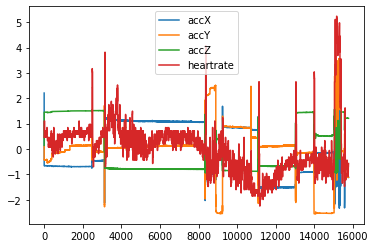

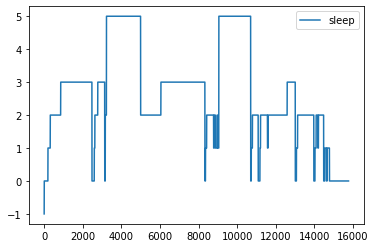

In [77]:
df_feature = pd.DataFrame(data = afterScaler, index = df_feature.index, columns = feature_columns)

df_feature.plot(), df_label.plot()

#8.2

##8.2 (a) SVM Model Training and Testing

In [78]:
Rseed = 42
x_train_set, x_test, y_train_set, y_test = train_test_split(df_feature, df_label, test_size = 0.3, random_state = Rseed)
x_train, x_validate, y_train, y_validate = train_test_split(x_train_set, y_train_set, test_size = 0.3, random_state = Rseed)

In [79]:
c_val = 100 
gmm =0.1
d = 2

svc_lin = SVC(kernel='linear', C=c_val)
svc_rbf = SVC(kernel='rbf', C=c_val, gamma=gmm)
svc_poly = SVC(kernel='poly', C=c_val, degree=d)

# Model Training
svc_rbf_pred = svc_rbf.fit(x_train, y_train)
svc_poly = svc_poly.fit(x_train, y_train)
# Model Testing
svc_rbf_pred = svc_rbf.predict(x_test)
svc_poly_pred = svc_poly.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##8.2(b) SVM Prediction Report

In [80]:
# Model Confusion Matrix of SVC_rbf, SVC_poly
print('Confusion RBF')
confusion_matrix(y_test,svc_rbf_pred)

Confusion RBF


array([[   0,    1,    0,    0,    0,    0],
       [   0,  285,   29,  164,   23,    3],
       [   0,   28,   85,  145,    6,    9],
       [   0,   18,   24, 1345,  102,   27],
       [   0,    4,    0,   60, 1336,    0],
       [   0,    0,    1,  198,    2,  835]])

In [81]:
print('Confusion Poly')
confusion_matrix(y_test,svc_poly_pred)

Confusion Poly


array([[   0,    1,    0,    0,    0,    0],
       [   0,  265,    0,  206,   25,    8],
       [   0,   26,    0,  224,   11,   12],
       [   0,    4,    0, 1276,  197,   39],
       [   0,    2,    0,  153, 1245,    0],
       [   0,    1,    0,  147,   32,  856]])

In [82]:
# Model Classification Report of SVC_rbf, SVC_poly
print('Classification RBF')
print(classification_report(y_test,svc_rbf_pred))

Classification RBF
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         1
         0.0       0.85      0.57      0.68       504
         1.0       0.61      0.31      0.41       273
         2.0       0.70      0.89      0.78      1516
         3.0       0.91      0.95      0.93      1400
         5.0       0.96      0.81      0.87      1036

    accuracy                           0.82      4730
   macro avg       0.67      0.59      0.61      4730
weighted avg       0.83      0.82      0.81      4730



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
print('Classification Poly')
print(classification_report(y_test,svc_poly_pred))

Classification Poly
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         1
         0.0       0.89      0.53      0.66       504
         1.0       0.00      0.00      0.00       273
         2.0       0.64      0.84      0.72      1516
         3.0       0.82      0.89      0.86      1400
         5.0       0.94      0.83      0.88      1036

    accuracy                           0.77      4730
   macro avg       0.55      0.51      0.52      4730
weighted avg       0.75      0.77      0.75      4730



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#8.3Hyperparameter Tuning (GridsearchCV)

In [ ]:
C_list = [0.1, 1.0, 10.0, 100.0, 200.0, 500.0]
Gamma_list = [0.01, 0.1, 1.0, 10]
d_list = [2, 3]

param_grid = {'C':C_list, 'kernel':('rbf','poly'),'gamma':Gamma_list, 'degree':d_list}

# Perform GridsearchCV() for each classification model

grid = GridSearchCV( SVC(), n_jobs = -1, scoring = 'accuracy', cv = 2, param_grid=param_grid)
grid_result = grid.fit(x_train, y_train)

In [ ]:
# Show best search results
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)

In [ ]:
grid_result.cv_results_['params']

In [ ]:
mean = grid_result.cv_results_['mean_test_score']
std = grid_result.cv_results_['std_test_score']
param = grid_result.cv_results_['params']
bar_mean_rbf = []
bar_mean_poly = []

bar_std_rbf = []
bar_std_poly = []

bar_param_rbf = []
bar_param_poly = []


for mean, stdev, param in zip(mean, std, param):
  print("Mean: %f Std: %f Model: %r" % (mean, stdev, param))
  if param['kernel'] == 'rbf':
    bar_mean_rbf.append(mean)
    bar_std_rbf.append(stdev)
    bar_param_rbf.appen(param)
  else:
    bar_mean_poly.append(mean)
    bar_std_poly.append(stdev)
    bar_param_poly.append(param)

In [ ]:
x = np.arange(len(bar_param_rbf))
w = 0.5
fig, ax = plt.subplots()
fig = plt.title('Criterion : RBF')
rect1 = plt.bar(x-w/2,bar_mean_rbf,w,color = 'b')
rect2 = plt.bar(x+w/2,bar_std_rbf,w,color = 'r')
ax.set_xticks(x, labels = bar_param_rbf,rotation = 90)
plt.subplots_adjust(bottom=0.50)
plt.show()

In [ ]:
fig = plt.title('Criterion : Poly')
rect1 = plt.bar(x-w/2,bar_mean_poly,w,color = 'b')
rect2 = plt.bar(x+w/2,bar_std_poly,w,color = 'r')
ax.set_xticks(x, labels = bar_param_poly,rotation = 90)
plt.subplots_adjust(bottom=0.50)
plt.show()